In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf 

from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils
import sklearn.metrics as metrics
import itertools

from tqdm import tqdm



In [ ]:
train_df = pd.read_csv('emnist-balanced-train.csv', header=None)
train_df.head()

In [ ]:
#split data into X,y
train_df.shape
X_train = train_df.loc[:, 1:]
y_train = train_df.loc[:, 0]
X_train.shape, y_train.shape

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
#label
label_map = pd.read_csv("emnist-balanced-mapping.txt", 
                        delimiter = ' ', 
                        index_col=0, 
                        header=None, 
                        squeeze=True)
label_map.head()

In [ ]:
label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

In [ ]:
W = 28
H = 28

In [29]:
#to rotate the image
def reshape_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [96]:
#preprocess the image: reshape_and_rotate to all images in X_train
X_train = np.apply_along_axis(reshape_and_rotate, 1, X_train.values)
X_train.shape

(112800, 28, 28)

In [97]:
#Normalize Data
X_train = X_train.astype('float32') / 255

In [98]:
#Hot Encode Label
number_of_classes = y_train.nunique()
number_of_classes

47

In [99]:
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_train.shape

(112800, 47)

In [100]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [101]:
# Reshape to fit model input shape
# Tensorflow (batch, width, height, channels)
X_train = X_train.reshape(-1, W, H, 1)
X_train.shape

(112800, 28, 28, 1)

In [102]:
# Split 10% as test size
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size= 0.1, 
                                                  random_state=88)

CNN model


In [30]:
model = Sequential()

#1st Convolution block
model.add(Conv2D(filters=256, kernel_size=(3,3), padding = 'same', activation='relu',input_shape=(W, H,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

#2nd Convolution block
model.add(Conv2D(filters=128, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())

#3rd Convolution block
model.add(Conv2D(filters=64, kernel_size=(3,3), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())

#4th Convolution block
model.add(Conv2D(filters=32, kernel_size=(3,3), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#flatten
model.add(Flatten())

#dense-dropout-dense-dropout-softmax
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(.4))

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(.4))

model.add(Dense(units=number_of_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 256)       2560      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       295040    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                      

In [87]:
optimizer_name = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint('my_model.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

In [47]:
#takes about 1.5 hour to finish the training
history = model.fit(X_train,
                    y_train, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=1, 
                    validation_split=0.1,
                    callbacks=[early_stopping, mcp_save])

Epoch 1/50
2855/2856 [============================>.] - ETA: 0s - loss: 1.2726 - accuracy: 0.6135
Epoch 1: val_loss improved from inf to 0.48124, saving model to my_model.h5
2856/2856 [==============================] - 267s 93ms/step - loss: 1.2725 - accuracy: 0.6136 - val_loss: 0.4812 - val_accuracy: 0.8322
Epoch 2/50
2855/2856 [============================>.] - ETA: 0s - loss: 0.6543 - accuracy: 0.7860
Epoch 2: val_loss improved from 0.48124 to 0.41064, saving model to my_model.h5
2856/2856 [==============================] - 285s 100ms/step - loss: 0.6543 - accuracy: 0.7860 - val_loss: 0.4106 - val_accuracy: 0.8531
Epoch 3/50
2855/2856 [============================>.] - ETA: 0s - loss: 0.5641 - accuracy: 0.8120
Epoch 3: val_loss improved from 0.41064 to 0.40229, saving model to my_model.h5
2856/2856 [==============================] - 293s 103ms/step - loss: 0.5641 - accuracy: 0.8120 - val_loss: 0.4023 - val_accuracy: 0.8517
Epoch 4/50
2855/2856 [============================>.] - ETA:

In [88]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

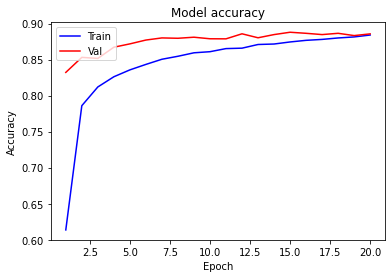

In [89]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

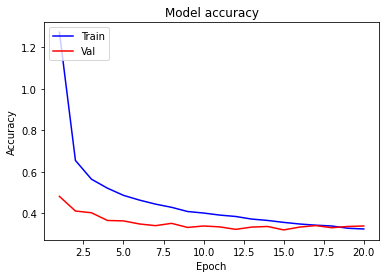

In [50]:
# loss curve
plotgraph(epochs, loss, val_loss)

### Test model

In [24]:
# Load best model
model = load_model('my_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 256)       2560      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                      

In [52]:
y_pred = model.predict(X_val)
y_pred.shape

(11280, 47)

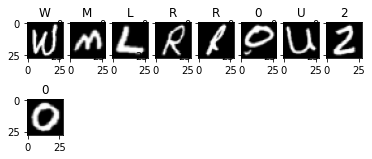

In [60]:
# choose from test set
for i in range(10, 19):
    plt.subplot(380 + (i%10+1))
    plt.imshow(X_val[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.title(label_dictionary[y_pred[i].argmax()])

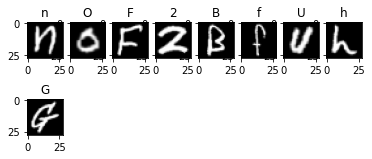

In [62]:
for i in range(40, 49):
    plt.subplot(380 + (i%10+1))
    plt.imshow(X_val[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.title(label_dictionary[y_pred[i].argmax()])

#### Test accuracy

In [63]:
model.evaluate(X_val, y_val)

353/353 [==============================] - 8s 23ms/step - loss: 0.3526 - accuracy: 0.8838


[0.3525715172290802, 0.8837766051292419]

##### Load test dataset & preprocess image to train dataset

In [64]:
test_df = pd.read_csv('emnist-balanced-test.csv', header=None)
test_df.shape

(18800, 785)

In [65]:
test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,18800.000000,18800.0,18800.0,18800.0,18800.0,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,...,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0
mean,23.000000,0.0,0.0,0.0,0.0,0.006064,0.019734,0.011277,0.009362,0.011277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,13.565021,0.0,0.0,0.0,0.0,0.528828,1.761298,1.054441,0.892318,1.517275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,11.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,23.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,35.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,46.000000,0.0,0.0,0.0,0.0,63.000000,213.000000,108.000000,95.000000,208.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
X_test = test_df.loc[:, 1:]
y_test = test_df.loc[:, 0]

X_test.shape, y_test.shape

((18800, 784), (18800,))

In [67]:
X_test = np.apply_along_axis(reshape_and_rotate, 1, X_test.values)
y_test = np_utils.to_categorical(y_test, number_of_classes)

X_test.shape, y_test.shape

((18800, 28, 28), (18800, 47))

In [68]:
X_test = X_test.astype('float32') / 255

In [69]:
X_test = X_test.reshape(-1, W, H, 1)
X_test.shape

(18800, 28, 28, 1)

In [70]:
model.evaluate(X_test, y_test)

588/588 [==============================] - 15s 25ms/step - loss: 0.3647 - accuracy: 0.8813


[0.3647109568119049, 0.8813297748565674]

In [28]:
#Confusion matrix

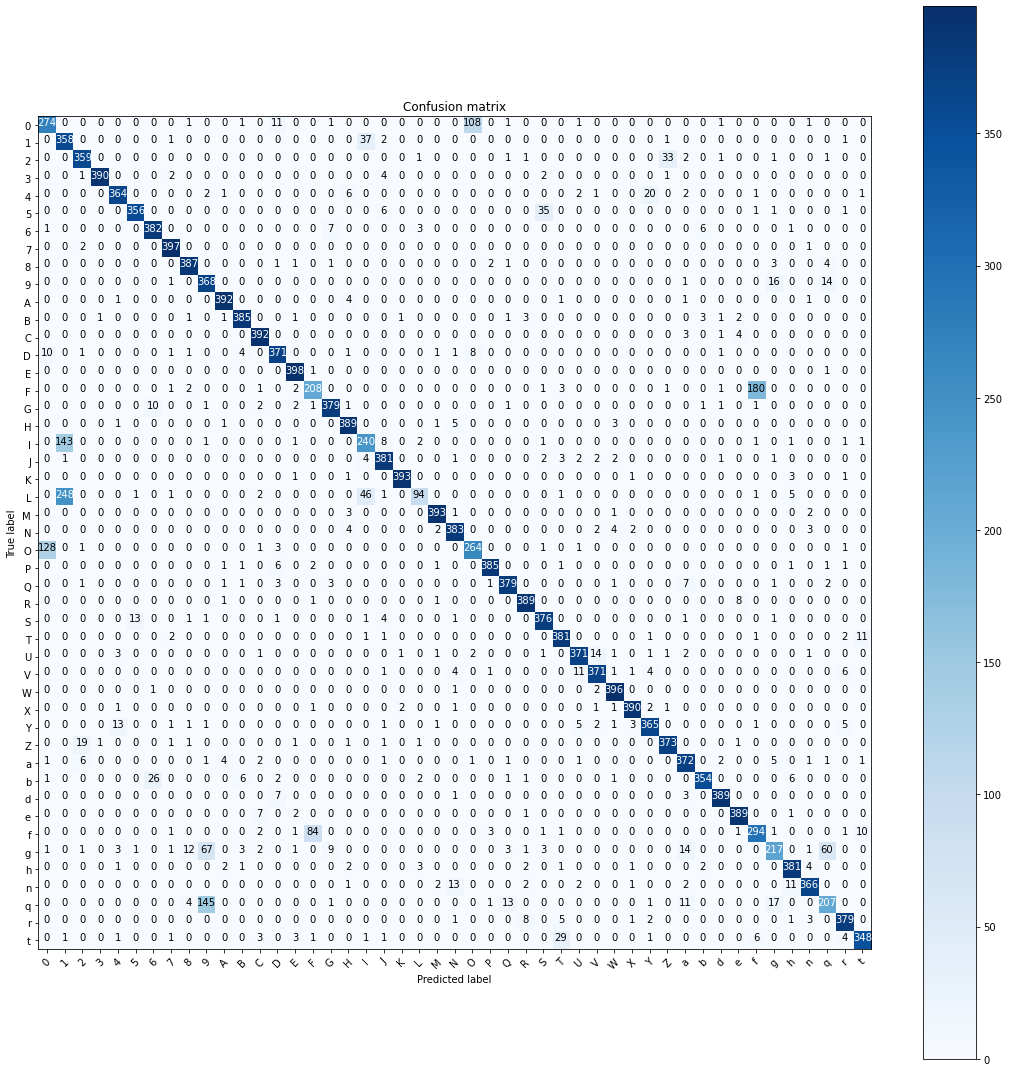

In [71]:
finalPrediction = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","a","b","d","e","f","g","h","n","q","r","t"]

y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, finalPrediction, rotation=45)
    plt.yticks(tick_marks, finalPrediction)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, classes=range(47))